# Regional Effects (unknown black-box function)

This tutorial use the same dataset with the previous [tutorial](./03_regional_effects_synthetic_f/), but instead of explaining the known (synthetic) predictive function, we fit a neural network on the data and explain the neural network. This is a more realistic scenario, since in real-world applications we do not know the underlying function and we only have access to the data. We advise the reader to first read the previous tutorial.

In [1]:
import numpy as np
import effector
import keras
import tensorflow as tf

np.random.seed(12345)
tf.random.set_seed(12345)

2025-02-06 00:17:52.569032: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-06 00:17:52.704586: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-06 00:17:52.795291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738797472.878258   48451 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738797472.903140   48451 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 00:17:53.100424: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Simulation example

### Data Generating Distribution

We will generate $N=500$ examples with $D=3$ features, which are in the uncorrelated setting all uniformly distributed as follows:

<center>

| Feature | Description                                | Distribution                 |
|---------|--------------------------------------------|------------------------------|
| $x_1$   | Uniformly distributed between $-1$ and $1$ | $x_1 \sim \mathcal{U}(-1,1)$ |
| $x_2$   | Uniformly distributed between $-1$ and $1$ | $x_2 \sim \mathcal{U}(-1,1)$ |
| $x_3$   | Uniformly distributed between $-1$ and $1$ | $x_3 \sim \mathcal{U}(-1,1)$ |

</center>

For the correlated setting we keep the distributional assumptions for $x_2$ and $x_3$ but define $x_1$ such that it is highly correlated with $x_3$ by: $x_1 = x_3 + \delta$ with $\delta \sim \mathcal{N}(0,0.0625)$.

In [2]:
def generate_dataset_uncorrelated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = np.random.uniform(-1, 1, size=N)
    return np.stack((x1, x2, x3), axis=-1)

def generate_dataset_correlated(N):
    x3 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x1 = x3 + np.random.normal(loc = np.zeros_like(x3), scale = 0.25)
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset for the uncorrelated and correlated setting
N = 1000
X_uncor_train = generate_dataset_uncorrelated(N)
X_uncor_test = generate_dataset_uncorrelated(10000)
X_cor_train = generate_dataset_correlated(N)
X_cor_test = generate_dataset_correlated(10000)

### Black-box function

We will use the following linear model with a subgroup-specific interaction term:
 $$ y = 3x_1I_{x_3>0} - 3x_1I_{x_3\leq0} + x_3$$ 
 
On a global level, there is a high heterogeneity for the features $x_1$ and $x_3$ due to their interaction with each other. However, this heterogeneity vanishes to 0 if the feature space is separated into subregions:

<center>

| Feature | Region      | Average Effect | Heterogeneity |
|---------|-------------|----------------|---------------|
| $x_1$   | $x_3>0$     | $3x_1$         | 0             |
| $x_1$   | $x_3\leq 0$ | $-3x_1$        | 0             |
| $x_2$   | all         | 0              | 0             |
| $x_3$   | $x_3>0$     | $x_3$          | 0             |
| $x_3$   | $x_3\leq 0$ | $x_3$          | 0             |

</center>

In [3]:
def generate_target(X):
    f = np.where(X[:,2] > 0, 3*X[:,0] + X[:,2], -3*X[:,0] + X[:,2])
    epsilon = np.random.normal(loc = np.zeros_like(X[:,0]), scale = 0.1)
    Y = f + epsilon
    return(Y)

# generate target for uncorrelated and correlated setting
Y_uncor_train = generate_target(X_uncor_train)
Y_uncor_test = generate_target(X_uncor_test)
Y_cor_train = generate_target(X_cor_train)
Y_cor_test = generate_target(X_cor_test)      

### Fit a Neural Network

We create a two-layer feedforward Neural Network, a weight decay of 0.01 for 100 epochs. We train two instances of this NN, one on the uncorrelated and one on the correlated setting. In both cases, the NN achieves a Mean Squared Error of about $0.17$ units.

In [4]:
# Train - Evaluate - Explain a neural network
model_uncor = keras.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model_uncor.compile(optimizer=optimizer, loss="mse")
model_uncor.fit(X_uncor_train, Y_uncor_train, epochs=100)
model_uncor.evaluate(X_uncor_test, Y_uncor_test)

Epoch 1/100


/home/givasile/miniconda3/envs/effector-dev/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-06 00:17:54.873513: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2025-02-06 00:17:54.873538: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: givasile-ubuntu-XPS-15-9500
2025-02-06 00:17:54.873544: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: givasile-ubuntu-XPS-15-9500
2025-02-06 00:17:54.873675: I external/local_xla/xla/stream_ex

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - loss: 3.0131
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 1.1789
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.5115
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.3425
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 0.2806
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 0.2401
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.2104
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.1892
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.1708
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 0.1544
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 0.1420
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.1326
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.1234
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.1156
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step -

0.07366398721933365

In [5]:
model_cor = keras.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model_cor.compile(optimizer=optimizer, loss="mse")
model_cor.fit(X_cor_train, Y_cor_train, epochs=100)
model_cor.evaluate(X_cor_test, Y_cor_test)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 2.1469
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 0.5191
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 0.2769
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.1994
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.1631
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 0.1387
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.1216
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.1110
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 0.1081
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.1048
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.1007
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0959
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.0922
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 0.0856
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 

0.02614535205066204

---
## PDP
### Uncorrelated setting
#### Global PDP

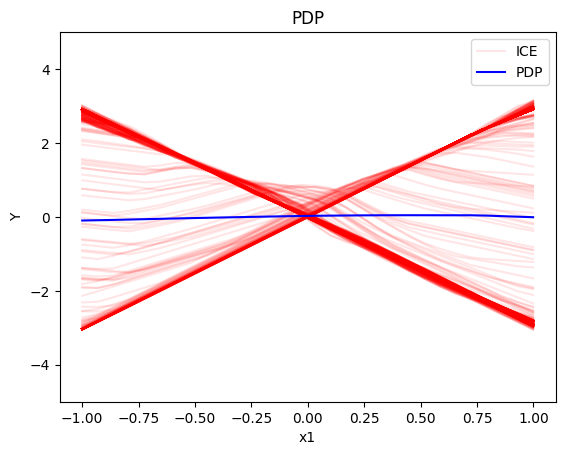

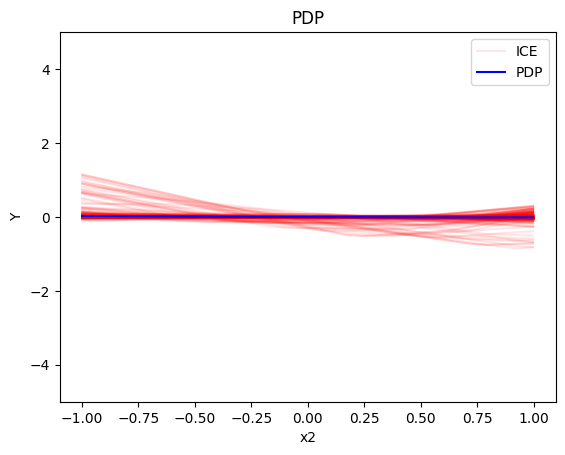

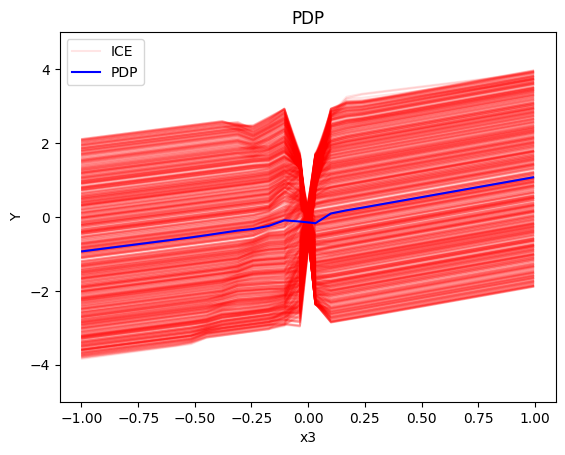

In [6]:
pdp = effector.PDP(data=X_uncor_train, model=model_uncor, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])

#### Regional PDP

In [7]:
regional_pdp = effector.RegionalPDP(data=X_uncor_train, model=model_uncor, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
regional_pdp.fit(features="all", heter_pcg_drop_thres=0.3, nof_candidate_splits_for_numerical=10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 52.46it/s]


In [8]:
regional_pdp.summary(features=0)



Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 3.35 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.0, heter: 0.11 || nof_instances:  1000 || weight: 1.00
        Node id: 2, name: x1 | x3  > 0.0, heter: 0.15 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 3.35
        Level 1, heter: 0.27 || heter drop : 3.08 (units), 92.01% (pcg)




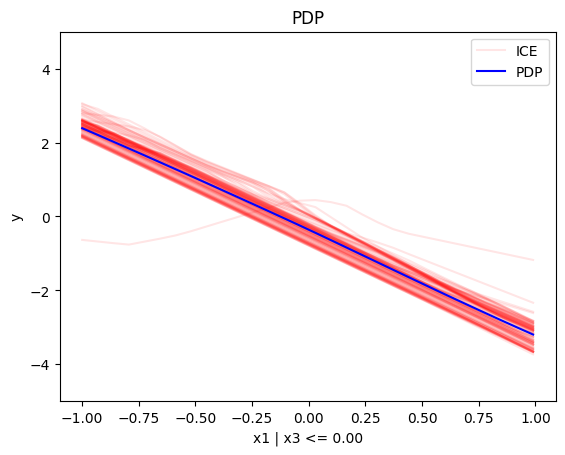

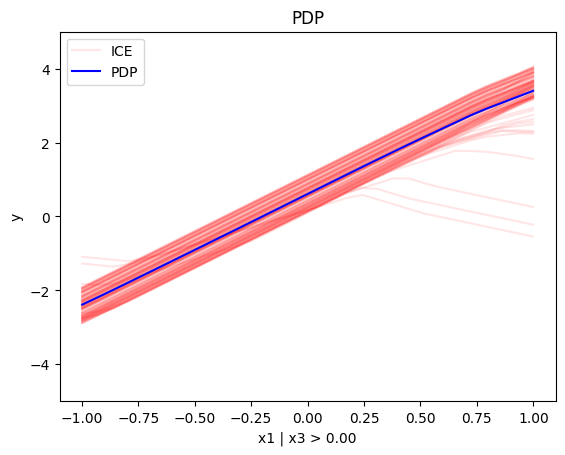

In [9]:
regional_pdp.plot(feature=0, node_idx=1, heterogeneity="ice", y_limits=[-5, 5])
regional_pdp.plot(feature=0, node_idx=2, heterogeneity="ice", y_limits=[-5, 5])

In [10]:
regional_pdp.summary(features=1)



Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 3.21 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 3.21




In [11]:
regional_pdp.summary(features=2)



Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 2.84 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x3 | x1 <= 0.0, heter: 0.70 || nof_instances:  1000 || weight: 1.00
        Node id: 2, name: x3 | x1  > 0.0, heter: 0.69 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 2.84
        Level 1, heter: 1.39 || heter drop : 1.45 (units), 51.09% (pcg)




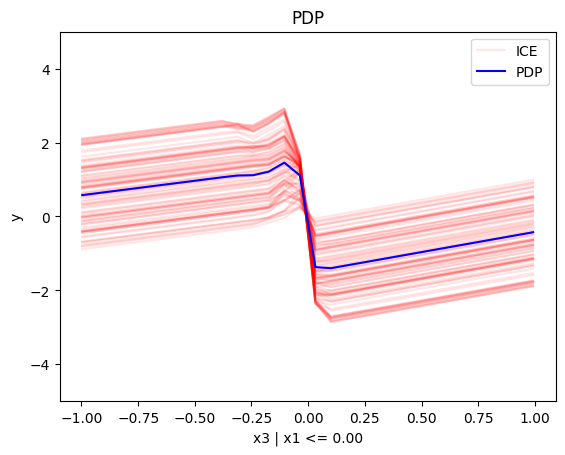

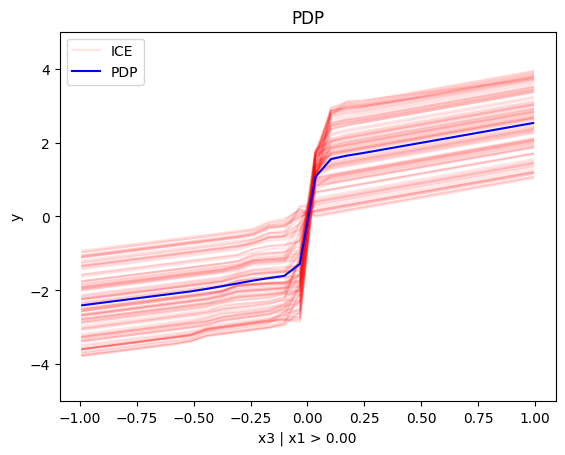

In [12]:
regional_pdp.plot(feature=2, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=2, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

#### Conclusion

For the Global PDP:

   * the average effect of $x_1$ is $0$ with some heterogeneity implied by the interaction with $x_1$. The heterogeneity is expressed with two opposite lines; $-3x_1$ when $x_1 \leq 0$ and $3x_1$ when $x_1 >0$
   * the average effect of $x_2$ to be $0$ without heterogeneity
   * the average effect of $x_3$ to be $x_3$ with some heterogeneity due to the interaction with $x_1$. The heterogeneity is expressed with a discontinuity around $x_3=0$, with either a positive or a negative offset depending on the value of $x_1^i$

--- 

For the Regional PDP:

* For $x_1$, the algorithm finds two regions, one for $x_3 \leq 0$ and one for $x_3 > 0$
  * when $x_3>0$ the effect is $3x_1$
  * when $x_3 \leq 0$, the effect is $-3x_1$
* For $x_2$ the algorithm does not find any subregion 
* For $x_3$, there is a change in the offset:
  * when $x_1>0$ the line is $x_3 - 3x_1^i$ in the first half and $x_3 + 3x_1^i$ later
  * when $x_1<0$ the line is $x_3 + 3x_1^i$ in the first half and $x_3 - 3x_1^i$ later

### Correlated setting


#### Global PDP

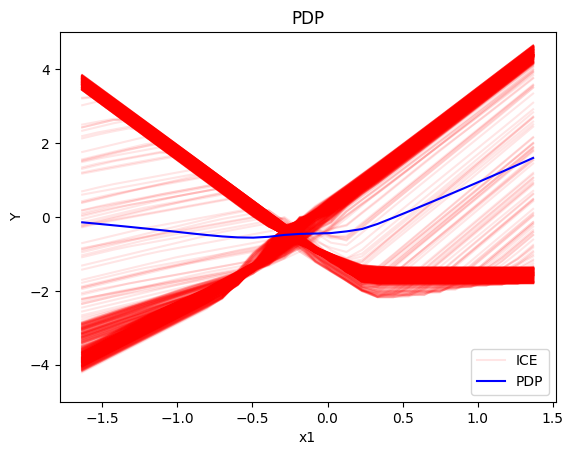

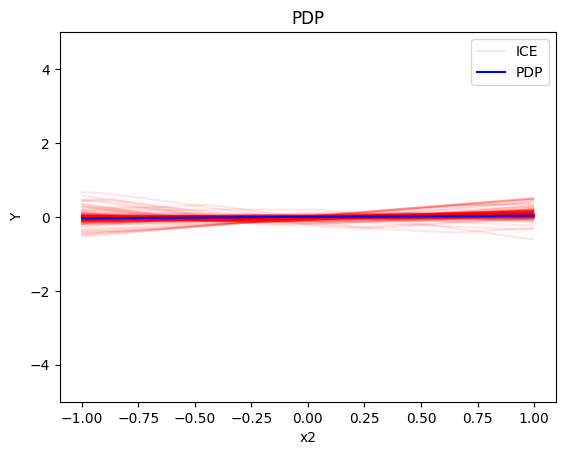

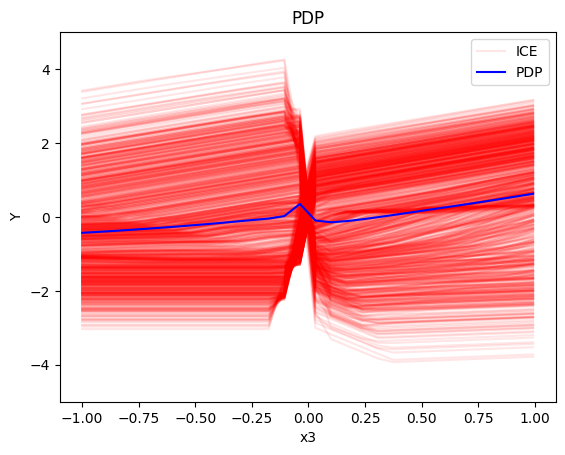

In [13]:
pdp = effector.PDP(data=X_cor_train, model=model_cor, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])

#### Regional-PDP

In [14]:
regional_pdp = effector.RegionalPDP(data=X_cor_train, model=model_cor, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
regional_pdp.fit(features="all", heter_pcg_drop_thres=0.4, nof_candidate_splits_for_numerical=10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 48.64it/s]


In [15]:
regional_pdp.summary(features=0)



Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 2.05 || nof_instances:   900 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.0, heter: 0.11 || nof_instances:   900 || weight: 1.00
        Node id: 2, name: x1 | x3  > 0.0, heter: 0.10 || nof_instances:   900 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 2.05
        Level 1, heter: 0.21 || heter drop : 1.85 (units), 89.81% (pcg)




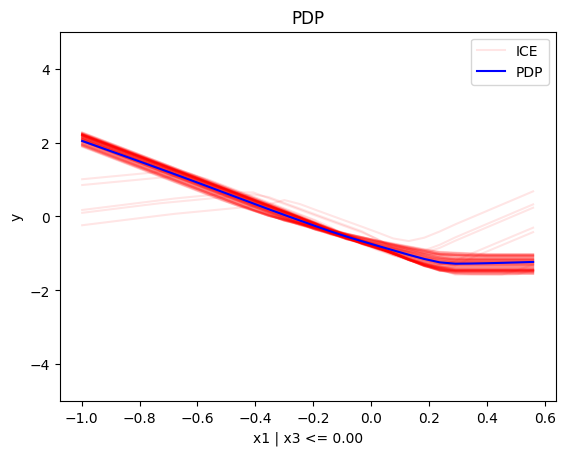

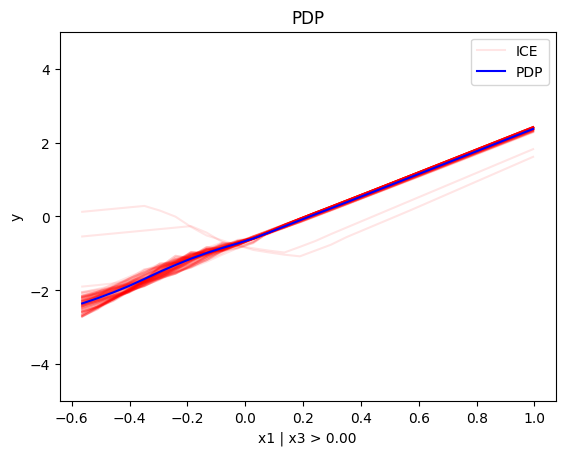

In [16]:
regional_pdp.plot(feature=0, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=0, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

In [17]:
regional_pdp.summary(features=1)



Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 1.25 || nof_instances:   900 || weight: 1.00
        Node id: 1, name: x2 | x1 <= 0.4, heter: 0.57 || nof_instances:   900 || weight: 1.00
        Node id: 2, name: x2 | x1  > 0.4, heter: 0.49 || nof_instances:   900 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 1.25
        Level 1, heter: 1.06 || heter drop : 0.19 (units), 15.48% (pcg)




In [18]:
regional_pdp.summary(features=2)



Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 1.82 || nof_instances:   900 || weight: 1.00
        Node id: 1, name: x3 | x1 <= -0.2, heter: 0.45 || nof_instances:   900 || weight: 1.00
        Node id: 2, name: x3 | x1  > -0.2, heter: 0.57 || nof_instances:   900 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 1.82
        Level 1, heter: 1.02 || heter drop : 0.80 (units), 44.10% (pcg)




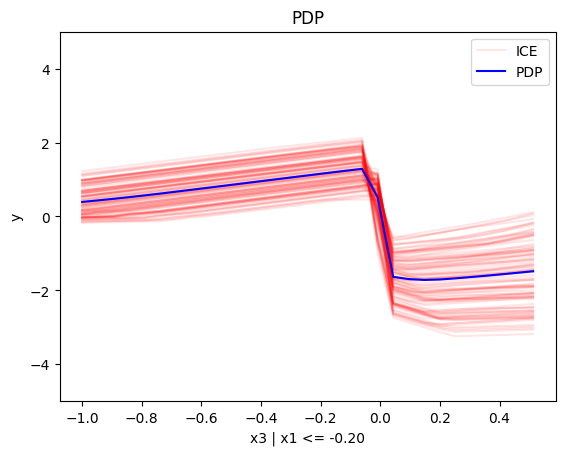

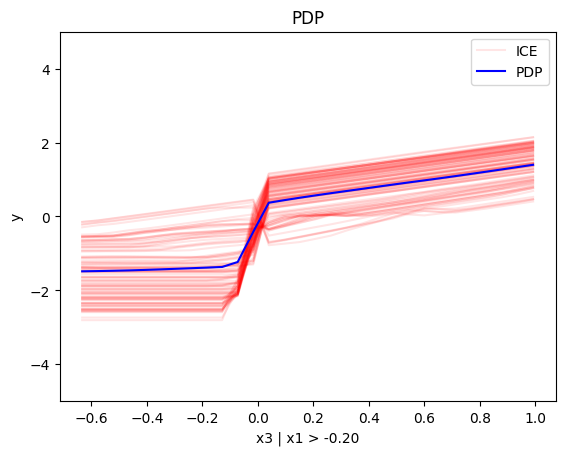

In [19]:
regional_pdp.plot(feature=2, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=2, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

#### Conclusion

## (RH)ALE

In [20]:
def model_uncor_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model_uncor(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_cor_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model_cor(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

### Uncorrelated setting

#### Global RHALE

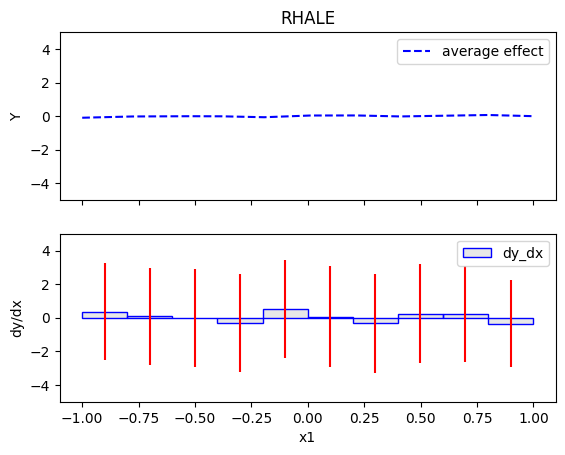

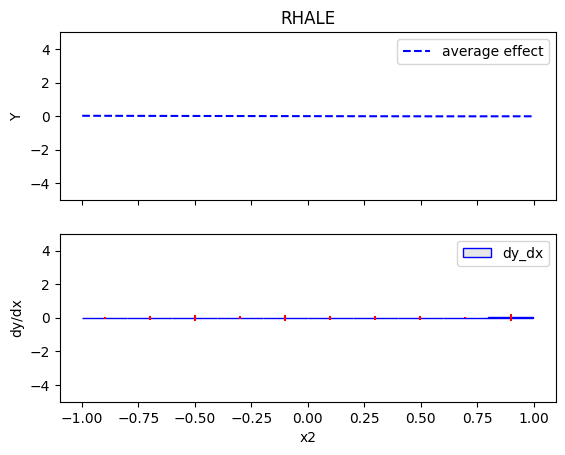

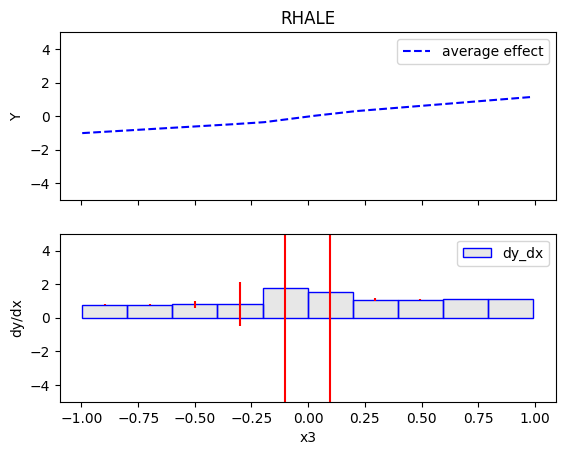

In [21]:
rhale = effector.RHALE(data=X_uncor_train, model=model_uncor, model_jac=model_uncor_jac, feature_names=['x1','x2','x3'], target_name="Y")

binning_method = effector.axis_partitioning.Fixed(10, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])

#### Regional RHALE


In [22]:
regional_rhale = effector.RegionalRHALE(
    data=X_uncor_train, 
    model=model_uncor, 
    model_jac= model_uncor_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.axis_partitioning.Fixed(11, min_points_per_bin=0)
regional_rhale.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    binning_method=binning_method,
    nof_candidate_splits_for_numerical=10
)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.63it/s]


In [23]:
regional_rhale.summary(features=0)



Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 8.34 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.0, heter: 0.31 || nof_instances:  1000 || weight: 1.00
        Node id: 2, name: x1 | x3  > 0.0, heter: 0.27 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 8.34
        Level 1, heter: 0.58 || heter drop : 7.76 (units), 93.08% (pcg)




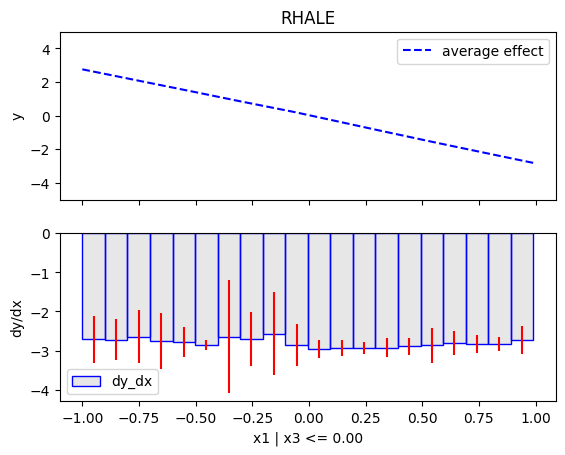

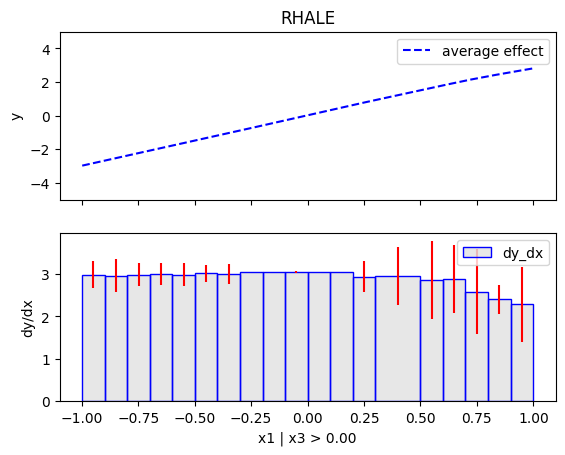

In [24]:
regional_rhale.plot(feature=0, node_idx=1, heterogeneity="std", centering=True, y_limits=[-5, 5])
regional_rhale.plot(feature=0, node_idx=2, heterogeneity="std", centering=True, y_limits=[-5, 5])

In [25]:
regional_rhale.summary(features=1)



Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.02 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.02




In [26]:
regional_rhale.summary(features=2)



Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 48.54 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 48.54




#### Conclusion

### Correlated setting

#### Global RHALE

In [27]:
rhale = effector.RHALE(data=X_cor_train, model=model_cor, model_jac=model_cor_jac, feature_names=['x1','x2','x3'], target_name="Y")

binning_method = effector.axis_partitioning.Fixed(10, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

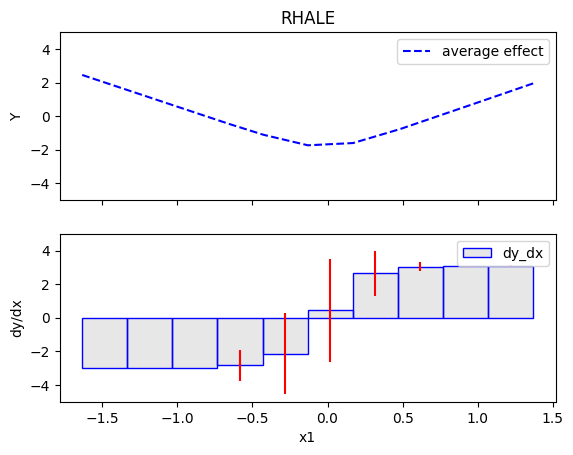

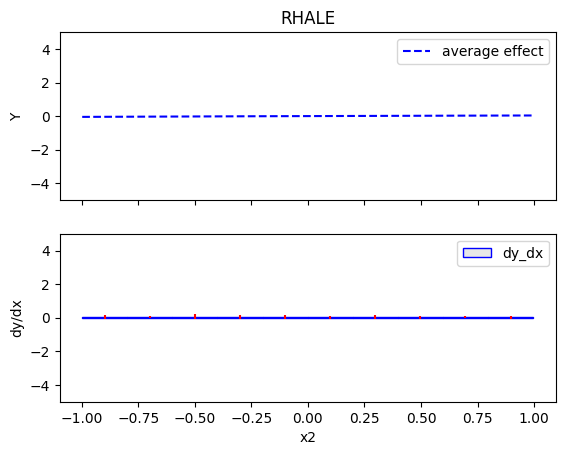

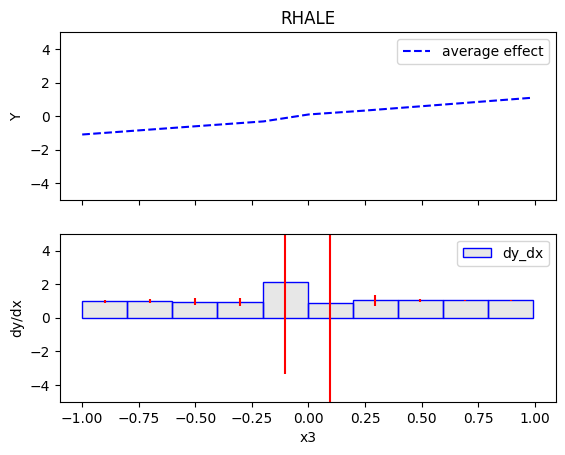

In [28]:
rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])

#### Regional RHALE

In [29]:
regional_rhale = effector.RegionalRHALE(
    data=X_cor_train, 
    model=model_cor, 
    model_jac= model_cor_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.axis_partitioning.Fixed(11, min_points_per_bin=0)
regional_rhale.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    binning_method=binning_method,
    nof_candidate_splits_for_numerical=10
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.77it/s]


In [30]:
regional_rhale.summary(features=0)



Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 2.33 || nof_instances:   900 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 2.33




In [31]:
regional_rhale.summary(features=1)



Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.01 || nof_instances:   900 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.01




In [32]:
regional_rhale.summary(features=2)



Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 15.84 || nof_instances:   900 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 15.84




#### Conclusion

## SHAP DP
### Uncorrelated setting
#### Global SHAP DP


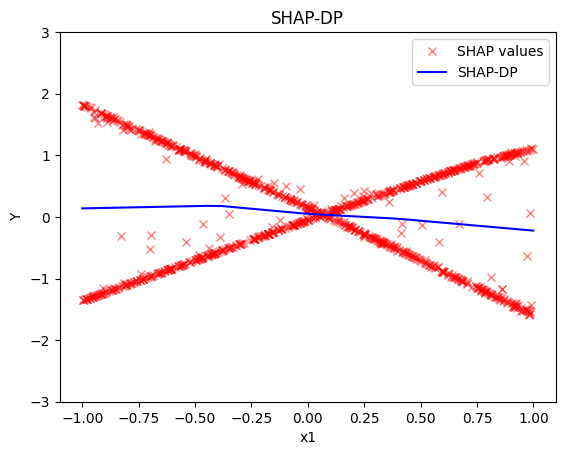

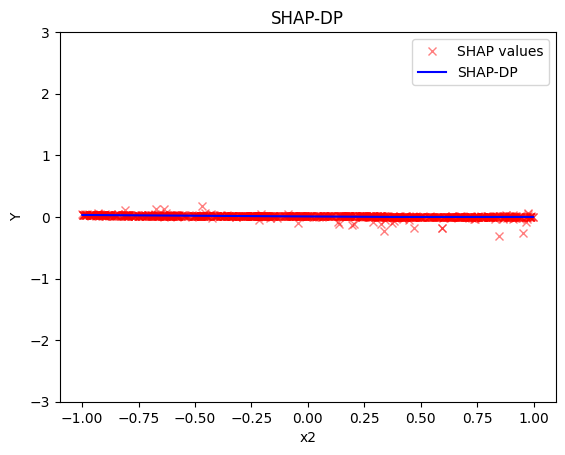

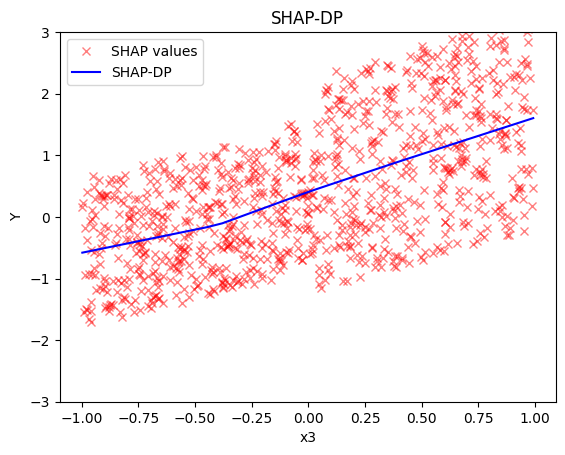

In [33]:
shap = effector.ShapDP(data=X_uncor_train, model=model_uncor, feature_names=['x1', 'x2', 'x3'], target_name="Y")
binning_method = effector.axis_partitioning.Fixed(nof_bins=5, min_points_per_bin=0)
shap.fit(features="all", binning_method=binning_method, centering=True)
shap.plot(feature=0, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=1, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=2, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])


#### Regional SHAP-DP

In [34]:
regional_shap = effector.RegionalShapDP(
    data=X_uncor_train,
    model=model_uncor,
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T)

regional_shap.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    nof_candidate_splits_for_numerical=10,
    binning_method = effector.axis_partitioning.Fixed(nof_bins=5, min_points_per_bin=0)
)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


In [35]:
regional_shap.summary(0)



Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 0.81 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.0, heter: 0.04 || nof_instances:  1000 || weight: 1.00
        Node id: 2, name: x1 | x3  > 0.0, heter: 0.03 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 0.81
        Level 1, heter: 0.07 || heter drop : 0.74 (units), 91.25% (pcg)




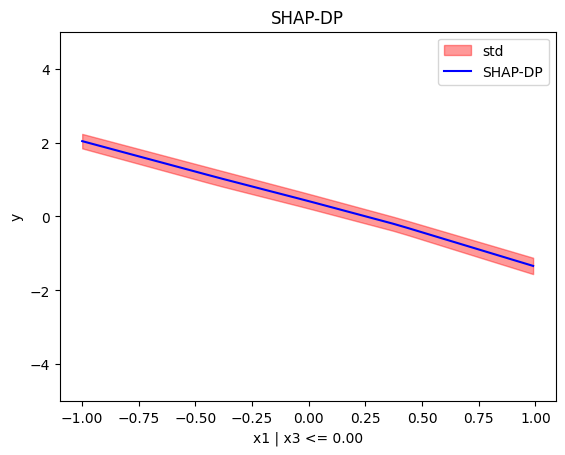

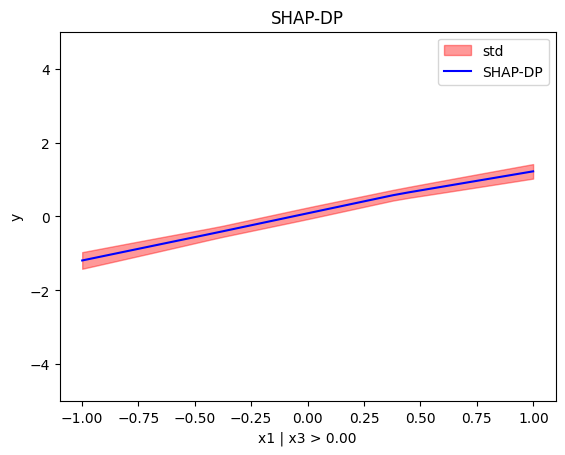

In [36]:
regional_shap.plot(feature=0, node_idx=1, heterogeneity="std", centering=True, y_limits=[-5, 5])
regional_shap.plot(feature=0, node_idx=2, heterogeneity="std", centering=True, y_limits=[-5, 5])

In [37]:
regional_shap.summary(features=1)



Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.00 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.00




In [38]:
regional_shap.summary(features=2)



Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.76 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x3 | x1 <= 0.0, heter: 0.25 || nof_instances:  1000 || weight: 1.00
        Node id: 2, name: x3 | x1  > 0.0, heter: 0.33 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.76
        Level 1, heter: 0.58 || heter drop : 0.17 (units), 22.98% (pcg)




#### Conclusion

### Correlated setting

#### Global SHAP-DP


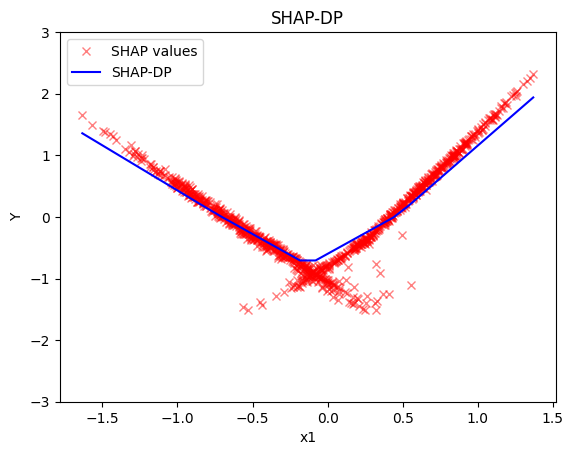

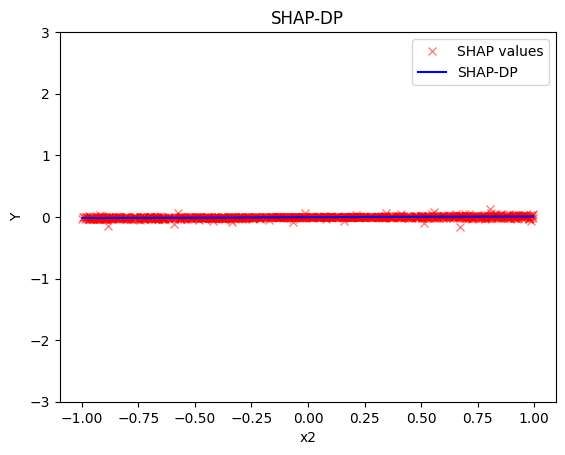

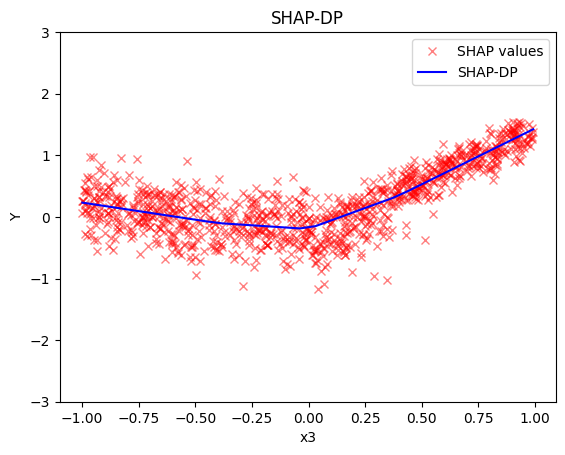

In [39]:

shap = effector.ShapDP(data=X_cor_train, model=model_cor, feature_names=['x1', 'x2', 'x3'], target_name="Y")
binning_method = effector.axis_partitioning.Fixed(nof_bins=5, min_points_per_bin=0)
shap.fit(features="all", binning_method=binning_method, centering=True)
shap.plot(feature=0, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=1, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=2, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])


#### Regional SHAP

In [40]:
regional_shap = effector.RegionalShapDP(
    data=X_cor_train,
    model=model_cor,
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T)

regional_shap.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    nof_candidate_splits_for_numerical=10,
    binning_method = effector.axis_partitioning.Fixed(nof_bins=5, min_points_per_bin=0)
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.38s/it]


In [41]:
regional_shap.summary(0)
regional_shap.summary(1)
regional_shap.summary(2)



Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 0.07 || nof_instances:   900 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 0.07




Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.00 || nof_instances:   900 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.00




Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.09 || nof_instances:   900 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.09




#### Conclusion

